In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
import torch
import torch.nn as nn
from torch import optim

import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
train=pd.read_csv('/content/drive/MyDrive/Train/HB_train.csv',header=0,index_col=None).iloc[:,1:]
test=pd.read_csv('/content/drive/MyDrive/Train/HB_test.csv',header=0,index_col=None).iloc[:,1:]
valid=pd.read_csv('/content/drive/MyDrive/Train/HB_val.csv',header=0,index_col=None).iloc[:,1:]

In [ ]:
if torch.cuda.is_available(): 
    print('El dispositivo que se usará a partir de ahora es ' + torch.cuda.get_device_name(0))
    device = torch.device("cuda:0")
else:
    print('Tu equipo no cuenta con un dispositivo compatible con CUDA')
    device = torch.device("cpu")

El dispositivo que se usará a partir de ahora es Tesla T4


In [ ]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.backends.cudnn.enables = False

In [ ]:
seed = 10
torch.manual_seed(seed)

In [ ]:
train.shape, valid.shape, test.shape

((924905, 72), (158555, 72), (237832, 72))

In [ ]:
df_train_np = np.stack([train[col].values for col in train], 1)
df_train_tensor = torch.tensor(df_train_np, dtype=torch.float)
df_train_tensor[0]

tensor([0.5923, 0.5796, 0.5691, 0.4801, 0.4738, 0.4480, 0.4475, 0.4350, 0.3983,
        0.5077, 0.5103, 0.5670, 0.5451, 0.5007, 0.5022, 0.5031, 0.4996, 0.4933,
        0.3741, 0.4679, 0.4847, 0.5132, 0.4613, 0.5132, 0.4814, 0.4685, 0.4733,
        0.5243, 0.5123, 0.5130, 0.4640, 0.5035, 0.4306, 0.4598, 0.4690, 0.4690,
        0.4736, 0.5191, 0.4567, 0.5965, 0.5951, 0.4804, 0.5351, 0.5453, 0.5380,
        0.5595, 0.5371, 0.4570, 0.5264, 0.5983, 0.5635, 0.4545, 0.5739, 0.3921,
        0.5596, 0.5379, 0.4197, 0.5272, 0.4553, 0.5232, 0.4630, 0.5263, 0.4200,
        0.5000, 0.5134, 0.4528, 0.5073, 0.4962, 0.5248, 0.5201, 0.5977, 0.5019])

In [ ]:
outputs_train_tensor = df_train_tensor

In [ ]:
df_valid_np = np.stack([valid[col].values for col in valid], 1)
df_valid_tensor = torch.tensor(df_valid_np, dtype=torch.float)
df_valid_tensor[0]

tensor([0.5256, 0.3952, 0.3370, 0.3831, 0.4637, 0.4443, 0.3219, 0.4128, 0.2540,
        0.5673, 0.4327, 0.2584, 0.4897, 0.4410, 0.4381, 0.4895, 0.4237, 0.4055,
        0.5336, 0.4719, 0.2635, 0.5277, 0.5005, 0.3759, 0.4211, 0.2079, 0.4427,
        0.4398, 0.4756, 0.3939, 0.4949, 0.3943, 0.4887, 0.5229, 0.3458, 0.5602,
        0.3014, 0.6592, 0.4714, 0.5994, 0.3405, 0.3559, 0.3259, 0.5128, 0.3978,
        0.3052, 0.5143, 0.5471, 0.8082, 0.1049, 0.6880, 0.6259, 0.3079, 0.5151,
        0.2973, 0.5592, 0.5424, 0.2413, 0.6275, 0.5514, 0.2759, 0.4877, 0.3473,
        0.4292, 0.4196, 0.6163, 0.6920, 0.2989, 0.5471, 0.5813, 0.3053, 0.5187])

In [ ]:
outputs_valid_tensor = df_valid_tensor

In [ ]:
train_data = TensorDataset(df_train_tensor, outputs_train_tensor)
valid_data = TensorDataset(df_valid_tensor, outputs_valid_tensor)

In [ ]:
batch_size = 1024
train_loader = DataLoader(train_data, batch_size, shuffle=False)
valid_loader = DataLoader(valid_data, batch_size, shuffle=False)

In [ ]:
col = 72

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(col, int(col/2))
        self.fc2 = nn.Linear(int(col/2), col)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        
        x = F.elu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Classifier()
torch.cuda.current_device()

0

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #betas #eps #weight_decay #amsgrad
model.to(device);

n_epochs = 100
valid_loss_min = np.Inf # track change in validation loss
train_losses, test_losses, accuracy_losses = [], [], []
start = time.process_time()
for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, images)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)   
    train_losses.append(train_loss)
    test_losses.append(valid_loss)
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.10f} \tValidation Loss: {:.10f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.10f} --> {:.10f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'data_b16_lr0001.pt')
        valid_loss_min = valid_loss
        
print(time.process_time() - start)

Epoch: 1 	Training Loss: 0.0094628425 	Validation Loss: 0.0052923821
Validation loss decreased (inf --> 0.0052923821).  Saving model ...
Epoch: 2 	Training Loss: 0.0026378219 	Validation Loss: 0.0032731119
Validation loss decreased (0.0052923821 --> 0.0032731119).  Saving model ...
Epoch: 3 	Training Loss: 0.0017542742 	Validation Loss: 0.0024645865
Validation loss decreased (0.0032731119 --> 0.0024645865).  Saving model ...
Epoch: 4 	Training Loss: 0.0013269851 	Validation Loss: 0.0019844415
Validation loss decreased (0.0024645865 --> 0.0019844415).  Saving model ...
Epoch: 5 	Training Loss: 0.0010734075 	Validation Loss: 0.0016490551
Validation loss decreased (0.0019844415 --> 0.0016490551).  Saving model ...
Epoch: 6 	Training Loss: 0.0009255776 	Validation Loss: 0.0014766595
Validation loss decreased (0.0016490551 --> 0.0014766595).  Saving model ...
Epoch: 7 	Training Loss: 0.0008527927 	Validation Loss: 0.0013976829
Validation loss decreased (0.0014766595 --> 0.0013976829).  Savi

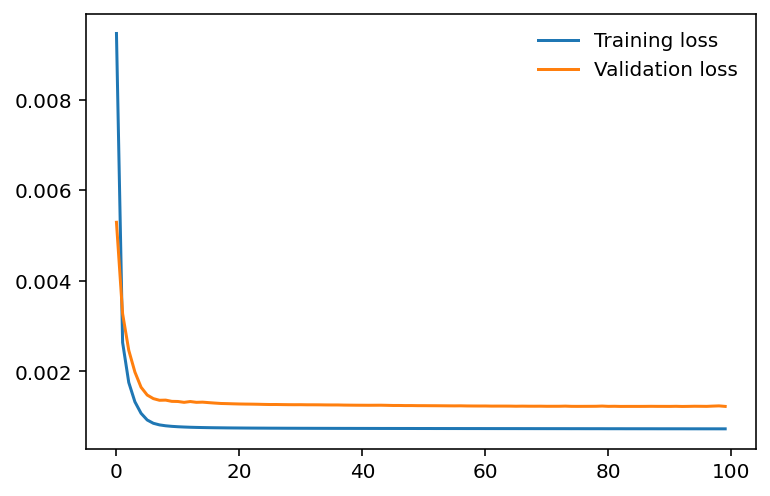

In [ ]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [ ]:
dfrb = pd.read_csv('/content/drive/MyDrive/Train/RB_train.csv').iloc[:,1:]
dfub = pd.read_csv('/content/drive/MyDrive/Train/UB_test.csv').iloc[:,1:]
dfcdb = pd.read_csv('/content/drive/MyDrive/Train/CDB_val.csv').iloc[:,1:]

In [ ]:
test = pd.concat([test.iloc[:5000], dfrb.iloc[:5000], dfub.iloc[:5000], dfcdb.iloc[:5000]])

In [ ]:
target = []
for i in range(0, 5000):
  target.append(1)

for i in range(0, 5000):
  target.append(2)

for i in range(0, 5000):
  target.append(3)

for i in range(0, 5000):
  target.append(4)

In [ ]:
df_test_np = np.stack([test[col].values for col in test], 1)
df_test_tensor = torch.tensor(df_test_np, dtype=torch.float)
df_test_tensor[0]

tensor([0.5033, 0.5067, 0.4989, 0.4650, 0.4750, 0.4908, 0.4469, 0.4560, 0.4616,
        0.5348, 0.5228, 0.5797, 0.4703, 0.4633, 0.5197, 0.4653, 0.5252, 0.5252,
        0.5203, 0.5674, 0.4743, 0.4578, 0.4727, 0.3850, 0.2852, 0.4204, 0.3574,
        0.5421, 0.5136, 0.5143, 0.4501, 0.5868, 0.4616, 0.5228, 0.5481, 0.5072,
        0.4458, 0.5093, 0.4966, 0.5901, 0.5593, 0.4715, 0.4042, 0.5065, 0.5860,
        0.4675, 0.5200, 0.5857, 0.4284, 0.5174, 0.5355, 0.5317, 0.4880, 0.5444,
        0.4054, 0.5139, 0.4870, 0.5053, 0.5138, 0.4982, 0.4556, 0.5084, 0.4736,
        0.5166, 0.5665, 0.5709, 0.4869, 0.5386, 0.5350, 0.4786, 0.6003, 0.5548])

In [ ]:
model.eval()

Classifier(
  (fc1): Linear(in_features=72, out_features=36, bias=True)
  (fc2): Linear(in_features=36, out_features=72, bias=True)
)

In [ ]:
w=df_test_tensor
w=w.cuda()
log_ps = model(w)
log_ps

tensor([[0.5693, 0.5803, 0.5560,  ..., 0.4782, 0.5723, 0.5465],
        [0.5750, 0.5471, 0.5809,  ..., 0.5037, 0.4420, 0.4942],
        [0.5975, 0.5812, 0.5764,  ..., 0.5777, 0.5252, 0.5317],
        ...,
        [0.5407, 0.5696, 0.5782,  ..., 0.6471, 0.6176, 0.6659],
        [0.5525, 0.5322, 0.5781,  ..., 0.7433, 0.6320, 0.5781],
        [0.5493, 0.5804, 0.5522,  ..., 0.6278, 0.6709, 0.6214]],
       device='cuda:0', grad_fn=<AddmmBackward>)

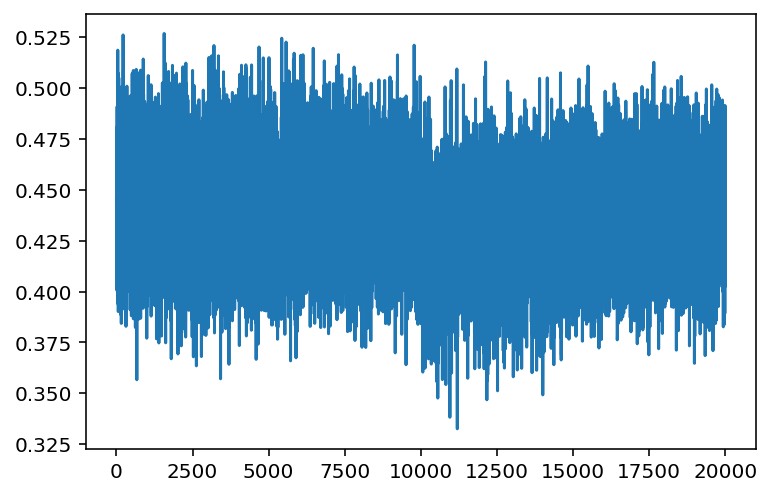

In [ ]:
plt.plot(log_ps.cpu().data.numpy()[:,8])

In [ ]:
error=abs(abs(test.values)-abs(log_ps.cpu().data.numpy()))
error

array([[0.06602141, 0.07352473, 0.05706764, ..., 0.00042075, 0.02798441,
        0.0082988 ],
       [0.07915998, 0.08427833, 0.09587204, ..., 0.00026371, 0.02456469,
        0.02588645],
       [0.10679956, 0.10659703, 0.10143716, ..., 0.01725523, 0.01627388,
        0.01511909],
       ...,
       [0.0773335 , 0.07636166, 0.08276392, ..., 0.00948103, 0.03905054,
        0.03659077],
       [0.09516757, 0.09652325, 0.09218921, ..., 0.0338499 , 0.06790122,
        0.05754915],
       [0.06511708, 0.099664  , 0.07186648, ..., 0.00527403, 0.02368131,
        0.02476218]])

In [ ]:
def metric_mse(X1,X2):
    X=abs(X1-X2)
    vector=[]
    for i in X:
        k=0
        c=0
        for j in range(X.shape[1]):
            k+=i[j]**2
        k=np.sqrt(k/X.shape[1])
        vector.append(k)
        c+=1
    
    return np.array(vector)

In [ ]:
abs(test.values)[0]-abs(log_ps.cpu().data.numpy())[0]

array([-0.06602141, -0.07352473, -0.05706764,  0.03641633,  0.04753489,
        0.01653997,  0.02891767,  0.03301113,  0.01549246,  0.00407832,
       -0.00322695,  0.01115798, -0.00551499, -0.00380752, -0.00549697,
       -0.00657168, -0.03695144,  0.00115196,  0.06532303,  0.02611978,
        0.02450781,  0.01038718,  0.03920311, -0.04638295, -0.02920735,
        0.01198578, -0.01715059,  0.0599216 ,  0.04727468, -0.02496602,
       -0.01239155,  0.04972307,  0.01808974,  0.03349528,  0.02092367,
        0.03455913, -0.03548803,  0.02154145, -0.01080303,  0.05298191,
       -0.00756761, -0.0717339 , -0.04560707,  0.01349354,  0.08683945,
       -0.01362323, -0.00498329,  0.04401219, -0.04093401, -0.01728915,
        0.01871175, -0.02028094, -0.01716288, -0.01492136, -0.00967834,
       -0.00016213, -0.07279414, -0.01591457, -0.00298691, -0.01119578,
        0.0153207 ,  0.00565105,  0.0026853 ,  0.06141857,  0.01618744,
        0.00456641,  0.01468183,  0.02002187,  0.00769895,  0.00

In [ ]:
error1=pd.DataFrame(metric_mse(abs(test.values),abs(log_ps.cpu().data.numpy())), columns=['error'])
error1

,error
0,0.033368
1,0.032767
2,0.032662
3,0.032429
4,0.039521
...,...
19995,0.049442
19996,0.043079
19997,0.036604
19998,0.046618


In [ ]:
error1['target']=target
error1

,error,target
0,0.033368,1
1,0.032767,1
2,0.032662,1
3,0.032429,1
4,0.039521,1
...,...,...
19995,0.049442,4
19996,0.043079,4
19997,0.036604,4
19998,0.046618,4


In [ ]:
result=error1

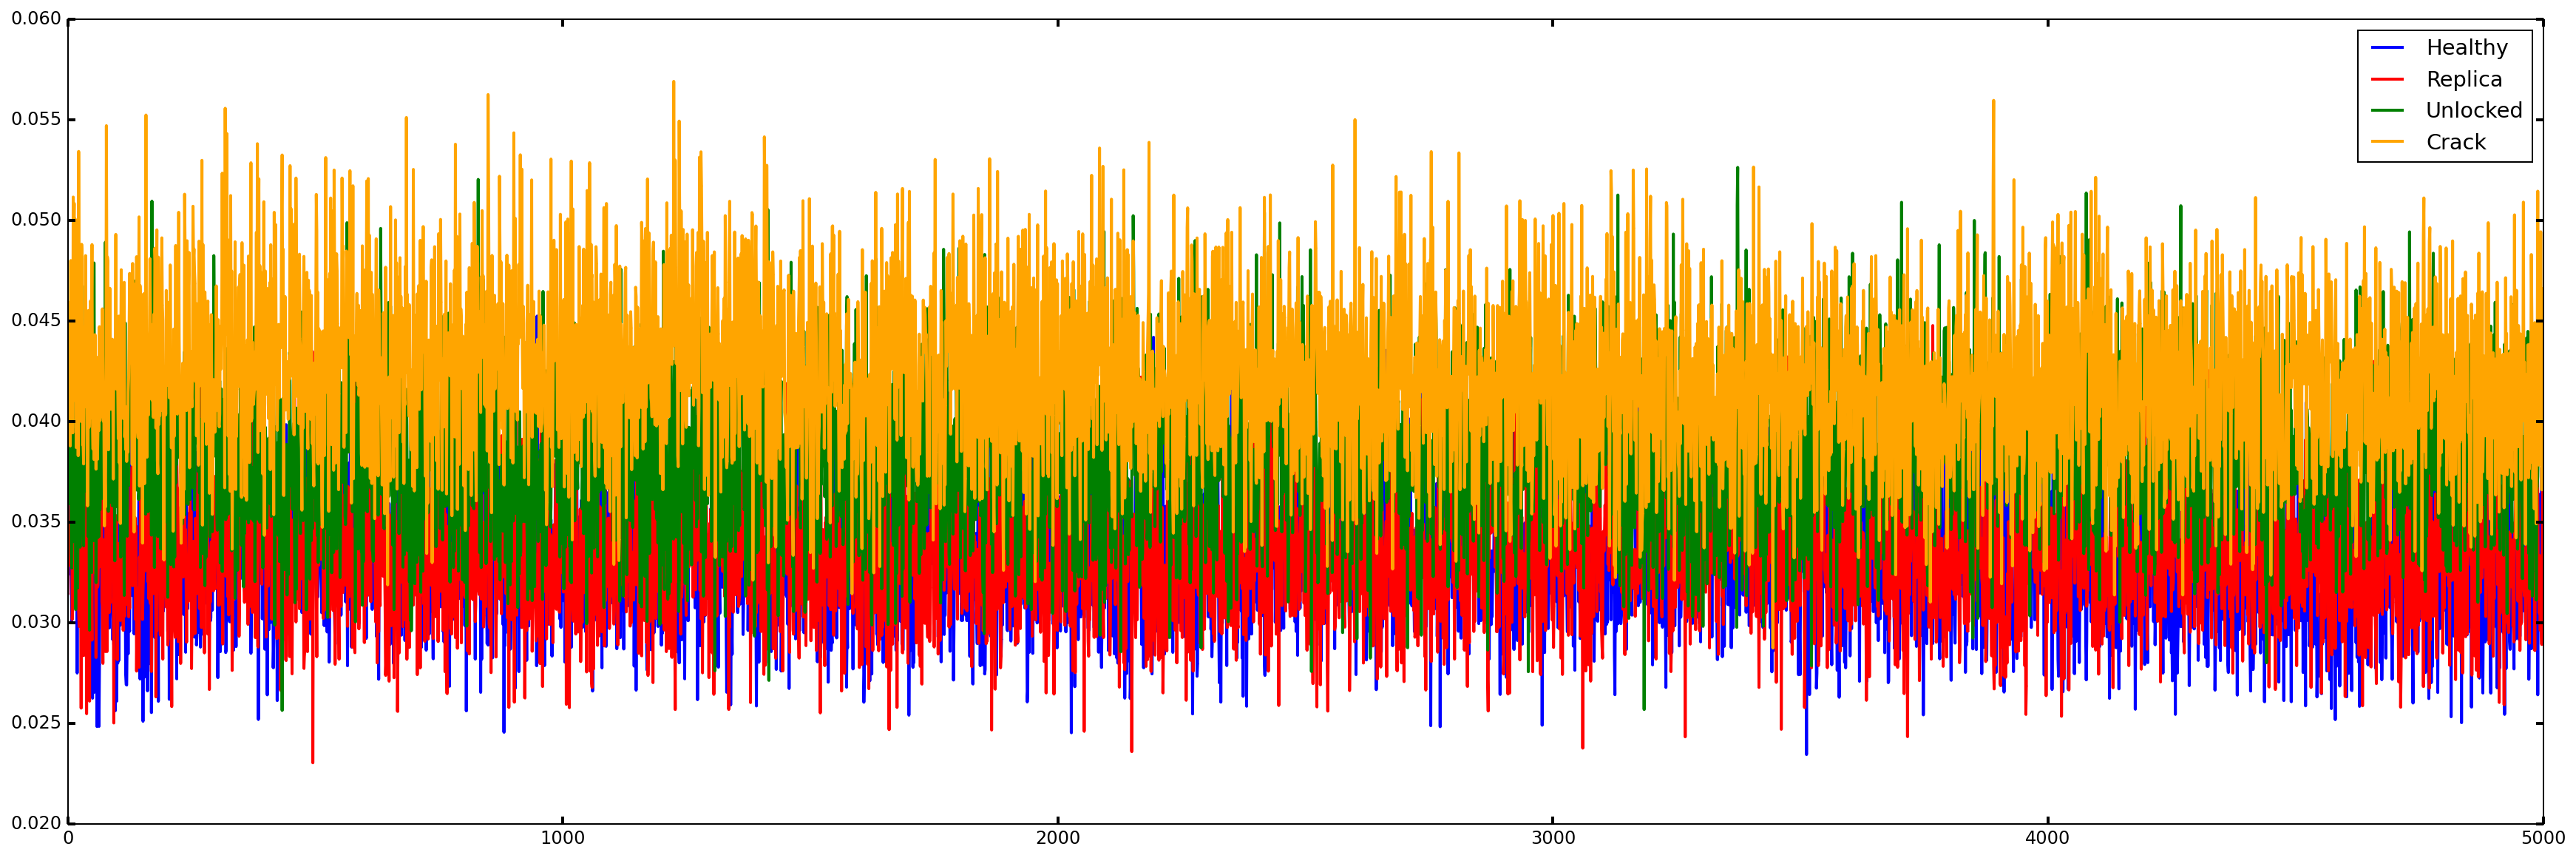

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.figure(figsize=(30,10))
plt.style.use('classic')


plt.plot(result[result.target==1.0]['error'].values, color="blue", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Healthy')
plt.plot(result[result.target==2.0]['error'].values, color="red", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Replica')
plt.plot(result[result.target==3.0]['error'].values, color="green", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Unlocked')
plt.plot(result[result.target==4]['error'].values, color="orange", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Crack')

plt.tick_params(which='both', width=2, length=5)
#plt.gcf().autofmt_xdate()
#plt.tight_layout()
plt.legend(frameon=True)
plt.savefig("wt2_temp.pdf",bbox_inches='tight')

In [ ]:
w1=np.concatenate((df_train_tensor,df_valid_tensor),axis=0)
w1 = torch.tensor(w1, dtype=torch.float)
w1=w1.cuda()
log_ps1 = model(w1)
log_ps1

tensor([[0.5808, 0.5702, 0.5709,  ..., 0.5077, 0.5701, 0.4759],
        [0.5902, 0.5833, 0.5789,  ..., 0.4634, 0.6070, 0.4402],
        [0.5359, 0.5808, 0.5626,  ..., 0.4775, 0.5233, 0.4860],
        ...,
        [0.7973, 0.4656, 0.4877,  ..., 0.4367, 0.4244, 0.4299],
        [0.5891, 0.6319, 0.4937,  ..., 0.4689, 0.4971, 0.4208],
        [0.6366, 0.6532, 0.3117,  ..., 0.3992, 0.5944, 0.4382]],
       device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
ws=600
error_train=metric_mse(abs(np.concatenate((train.values,valid.values),axis=0)),abs(log_ps1.cpu().data.numpy()))
error_train=pd.Series(error_train).rolling(ws).mean()[ws-1:].values
mean=np.mean(error_train)
std=np.std(error_train)

In [ ]:
np.max(error_train)

0.044883135180049244

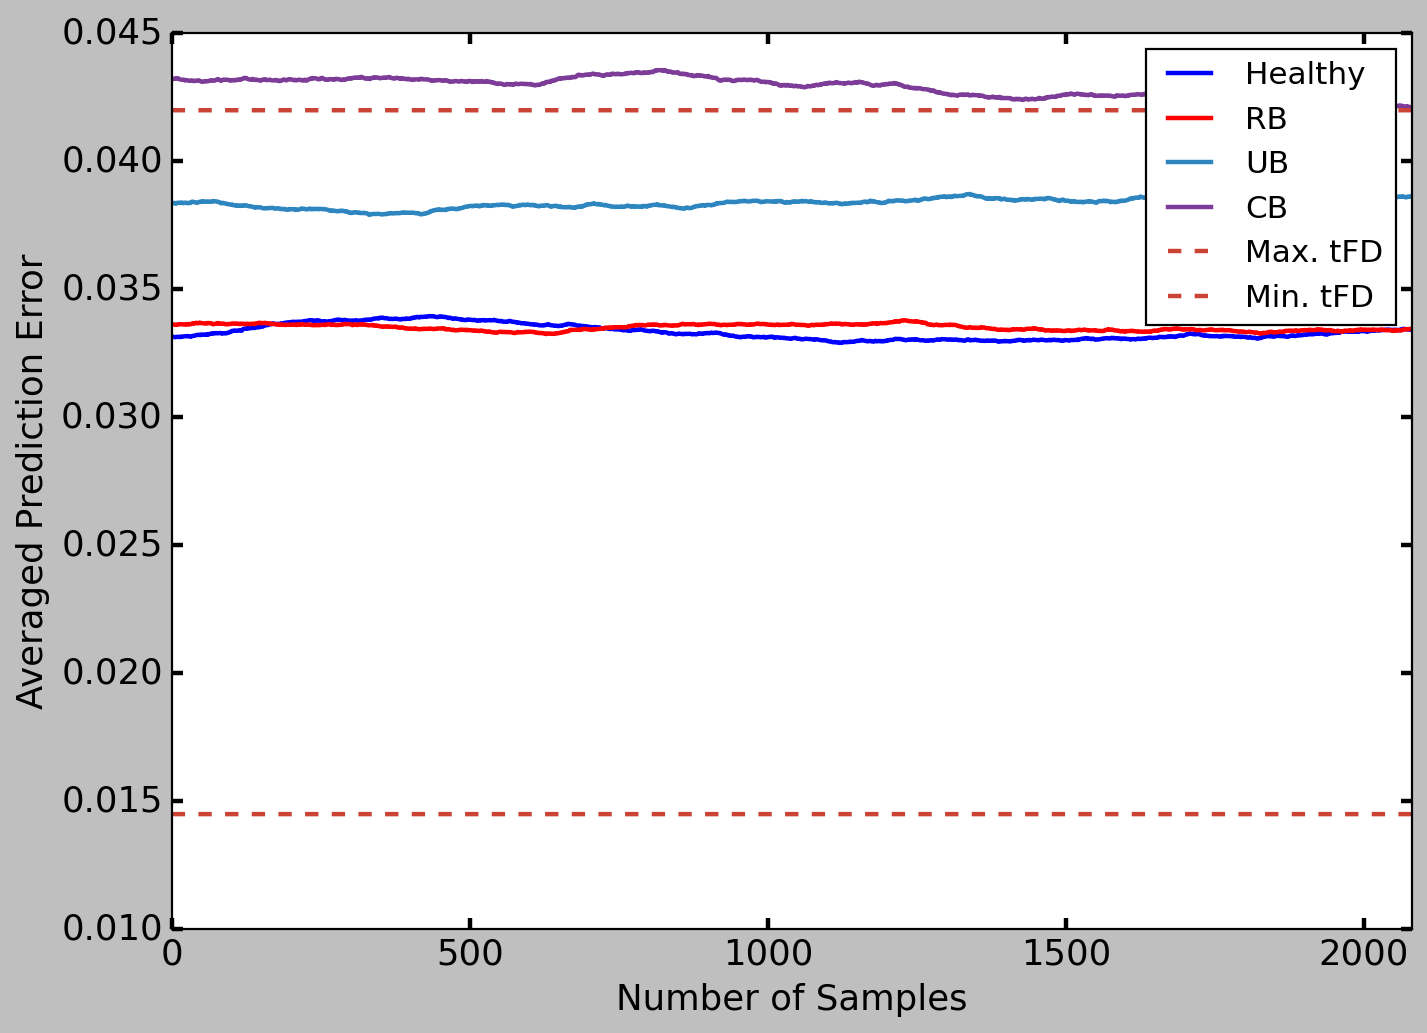

In [ ]:
plt.figure(figsize=(10,7))
plt.style.use('classic')
plt.rcParams['font.size'] = '16'
#plt.plot(diferencia, label='diferencia')
#plt.plot(datatest1["target"], label='target')
p=len(result[result.target==1]['error'].rolling(ws).mean()[ws-1:].values)

#plt.plot(error_train, color="lime", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Train')


plt.plot(result[result.target==1]['error'].rolling(ws).mean()[ws-1:].values, color="blue", marker=".", markersize=1, linestyle='solid',linewidth=2,label='Healthy')
plt.plot(result[result.target==2]['error'].rolling(ws).mean()[ws-1:].values, color="red", marker=".", markersize=1, linestyle='solid',linewidth=2,label='RB')
plt.plot(result[result.target==3]['error'].rolling(ws).mean()[ws-1:].values, color=[i/255 for i in (46, 134, 193)], marker=".", markersize=1, linestyle='solid',linewidth=2,label='UB')
plt.plot(result[result.target==4]['error'].rolling(ws).mean()[ws-1:].values, color=[i/255 for i in (125, 60, 152 )], marker=".", markersize=1, linestyle='solid',linewidth=2,label='CB')

plt.xlabel('Number of Samples', fontsize=16)
plt.ylabel('Averaged Prediction Error', fontsize=16)
plt.plot([mean+3*std]*p, color=[i/255 for i in (203, 67, 53 )], linestyle='--',linewidth=2,label='Max. tFD')
plt.plot([mean-3*std]*p, color=[i/255 for i in (203, 67, 53 )], linestyle='--',linewidth=2,label='Min. tFD')
#plt.plot([np.max(error_train)]*p, color="skyblue", linestyle='--',linewidth=2,label='Lower threshold')
plt.xlim(right=2080)
plt.tick_params(which='both', width=2, length=5)
#plt.gcf().autofmt_xdate()
#plt.tight_layout()
plt.legend(frameon=True,fontsize=14)
plt.savefig("J3RESULTS.pdf",bbox_inches='tight')